<a href="https://colab.research.google.com/github/villasen/colab_notebooks/blob/master/6Classes_ESC_50_split_full_integer_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/villasen/small-urban-sound-dataset
!rm -r sample_data

Cloning into 'small-urban-sound-dataset'...
remote: Enumerating objects: 35111, done.
remote: Total 35111 (delta 0), reused 0 (delta 0), pack-reused 35111
Receiving objects: 100% (35111/35111), 943.35 MiB | 15.12 MiB/s, done.
Resolving deltas: 100% (12608/12608), done.
Checking out files: 100% (43821/43821), done.


In [0]:
MFCC=14

In [4]:
import keras
from keras import layers
from keras import models
from keras import backend as K
from keras import optimizers
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
import librosa
import librosa.display
import tensorflow
import scipy
import os, shutil
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from six.moves import urllib
import sys
import tarfile
import os.path
from os import path
from tensorflow.python.ops import io_ops
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
import matplotlib.pyplot as plt
import librosa.display

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from numpy  import array
from tensorflow.contrib.quantize.python import fold_batch_norms
from tensorflow.contrib.quantize.python import quantize
from tensorflow.python.framework import ops
print(tf.__version__)






########### FUNCTIONS

def urban_wav2mfcc(file_path, max_pad_len):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320)
      
    pad_width = max_pad_len - mfcc.shape[1]
    #print(max_pad_len)
    #print(mfcc.shape[1])
    #print(pad_width)
    if pad_width < 0: 
      print(mfcc.shape[1])
      print(pad_width)
      print("error in "+ file_path)
    
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc 


  
  
def load_wav_file(wav_file):
  with tf.Session(graph=tf.Graph()) as sess:
      wav_filename_placeholder = tf.placeholder(tf.string, [])
      wav_loader = io_ops.read_file(wav_filename_placeholder)
      wav_decoder = contrib_audio.decode_wav(wav_loader, desired_channels=1)
      return sess.run(
          wav_decoder,
          feed_dict={wav_filename_placeholder: wav_file}).audio.flatten()


def get_mfccs(file):
  try:
      wave, sr = librosa.load(wavfile , mono=True, sr=None)
      mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320, norm='ortho')
      mfcc_scaled = np.mean(mfcc.T, axis=0)
      
  except Exception as error:
    print("Error found handling file: ", file)
    return None
  
  return mfcc_scaled
      
def normalize_data(mfcc_file, mean, std_dev ):
  norm_file = (mfcc_file - (mean)) / std_dev
  return norm_file



1.15.0


In [0]:
# Original model
def build_urban_model():
 return keras.Sequential([
      
    keras.layers.Conv2D(64, (4,MFCC), strides=(2,2), padding='same', activation='relu', input_shape=(MFCC,51,1), kernel_regularizer=keras.regularizers.l2(0.001)),     

# Depthwise layers
    keras.layers.Dropout(0.5), 
    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

      
    keras.layers.AveragePooling2D(pool_size=(5, 25), strides=(2,2), padding='valid', data_format=None),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(data_format=None),
    keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001),  activation='relu'),
  
      
    keras.layers.Dense(6, activation='softmax')     
      
      
  ])  


In [0]:
# trying new model copying from 8K
def build_urban_model():
 return keras.Sequential([
      
    keras.layers.Conv2D(64, (4,MFCC), strides=(2,2), padding='same', activation='relu', input_shape=(MFCC,51,1), kernel_regularizer=keras.regularizers.l2(0.001)),     

# Depthwise layers
    keras.layers.Dropout(0.5), 
    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

      
    keras.layers.AveragePooling2D(pool_size=(5, 25), strides=(2,2), padding='valid', data_format=None),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(data_format=None),
    keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001),  activation='relu'),
  
      
    keras.layers.Dense(6, activation='softmax')     
      
      
  ])  

In [6]:
import tensorflow as tf
tf.enable_eager_execution()
import os.path
from os import path



DATA_PATH= '/content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/'



labels = os.listdir('small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/')
print(labels)

test_single_file = '/content/test_single_file/'
if path.exists('/content/test_single_file/') :
    print ("folder test_single exits, removing")
    !rm -rf /content/test_single_file
os.mkdir(test_single_file)

target_npy_files = "/content/target_npy_files/"
if path.exists("/content/target_npy_files/") :
    print ("folder target_npy_files exits, removing")
    !rm -rf /content/target_npy_files
os.mkdir(target_npy_files)


target_txt_files = "/content/target_txt_files/"
if path.exists("/content/target_txt_files/") :
    print ("folder target_txt_files folder exits, removing")
    !rm -rf /content/target_txt_files
os.mkdir(target_txt_files)




# dog
if path.exists("/content/test_single_file/dog") :
     print ("folder test_single_file/dog exits, removing")
     !rm -rf /content/test_single_file/dog
os.mkdir('/content/test_single_file/dog')



# clapping
if path.exists("/content/test_single_file/clapping") :
     print ("folder test_single_file/clapping exits, removing")
     !rm -rf /content/test_single_file/clapping
os.mkdir('/content/test_single_file/clapping')

# door knock
if path.exists("/content/test_single_file/door_knock") :
    print ("folder test_single_file/door_knock exits, removing")
    !rm -rf /content/test_single_file/door_knock
os.mkdir('/content/test_single_file/door_knock')

# clock alarm
if path.exists("/content/test_single_file/clock_alarm") :
    print ("folder test_single_file/clock_alarm exits, removing")
    !rm -rf /content/test_single_file/clock_alarm
os.mkdir('/content/test_single_file/clock_alarm')

# glass_breaking
if path.exists("/content/test_single_file/glass_breaking") :
    print ("folder test_single_file/glass_breaking exits, removing")
    !rm -rf /content/test_single_file/glass_breaking
os.mkdir('/content/test_single_file/glass_breaking')

# fireworks
if path.exists("/content/test_single_file/fireworks") :
    print ("folder test_single_file/fireworks exits, removing")
    !rm -rf /content/test_single_file/fireworks
os.mkdir('/content/test_single_file/fireworks')

['frog', 'thunderstorm', 'brushing_teeth', 'Helicopter', 'handsaw', 'keyboard_typing', 'chirping_birds', 'dog', 'toilet_flush', 'train', 'hen', 'drinking_sipping', 'washing_machine', 'pouring_water', 'snoring', 'crow', 'can_opening', 'cat', 'vacuum_cleaner', 'rain', 'crackling_fire', 'sneezing', 'cow', 'sheep', 'rooster', 'clock_alarm', 'glass_breaking', 'clapping', 'crying_baby', 'insects', 'wind', 'water_drops', 'church_bells', 'clock_tick', '_background_noise_', 'engine', 'airplane', 'laughing', 'siren', 'breathing', 'crickets', 'sea_waves', 'door_knock', 'coughing', 'footsteps', 'mouse_click', 'pig', 'door_wood_creacks', 'fireworks', 'car_horn', 'chainsaw']


In [0]:
!cp  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clapping/clapping-E-3-177082-A.wav  /content/test_single_file/clapping/
!cp  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/dog/dog-A-5-208030-A.wav  /content/test_single_file/dog/
!cp  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/door_knock/door_knock-B-1-101336-A.wav  /content/test_single_file/door_knock/
!cp  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clock_alarm/clock_alarm-A-2-104476-A.wav  /content/test_single_file/clock_alarm/
!cp  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/glass_breaking/glass_breaking-B-4-204777-B.wav /content/test_single_file/glass_breaking/
!cp  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/fireworks/fireworks-A-2-117615-D.wav  /content/test_single_file/fireworks/

In [0]:
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clapping/clapping-E-4-189828-A.wav /content/test_single_file/clapping/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/dog/dog-E-3-144028-A.wav  /content/test_single_file/dog/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/door_knock/door_knock-A-2-133889-A.wav  /content/test_single_file/door_knock/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clock_alarm/clock_alarm-B-3-117883-A.wav  /content/test_single_file/clock_alarm/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/glass_breaking/glass_breaking-A-1-88807-A.wav  /content/test_single_file/glass_breaking/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/fireworks/fireworks-A-4-119648-A.wav  /content/test_single_file/fireworks/

In [0]:
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clapping/clapping-E-2-25292-A.wav /content/test_single_file/clapping/  
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/dog/dog-D-5-208030-A.wav  /content/test_single_file/dog/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/door_knock/door_knock-A-5-250026-B.wav  /content/test_single_file/door_knock/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clock_alarm/clock_alarm-B-3-132340-A.wav  /content/test_single_file/clock_alarm/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/glass_breaking/glass_breaking-A-4-212698-A.wav  /content/test_single_file/glass_breaking/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/fireworks/fireworks-E-2-117617-A.wav  /content/test_single_file/fireworks/

(16000,)
16000


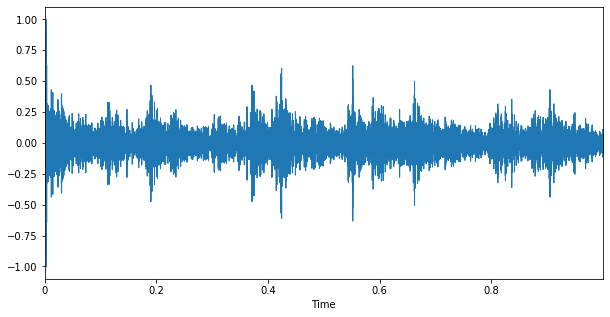

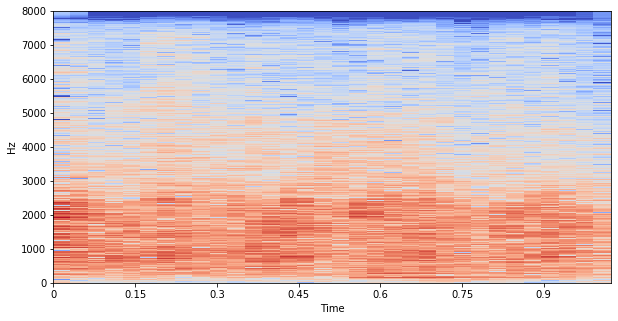

In [39]:
x, sr= librosa.load('test_single_file/clapping/clapping-E-3-177082-A.wav', sr=16000)
print(x.shape)
print(sr)

import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10,5))
librosa.display.waveplot(x, sr=sr)


X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

import IPython.display as ipd
ipd.Audio('test_single_file/dog/dog-A-5-208030-A.wav')

(16000,)
16000


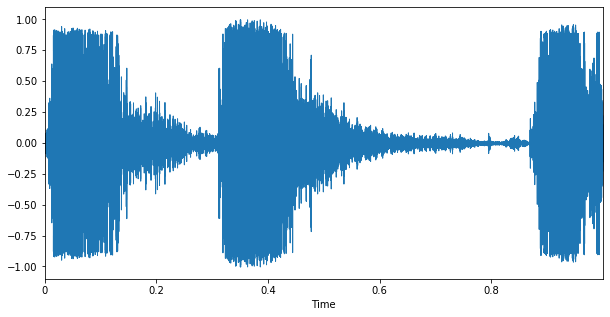

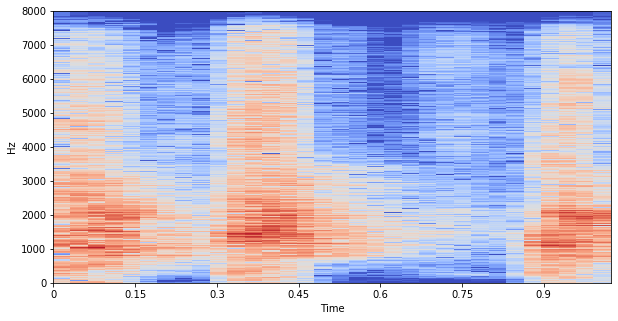

In [38]:
x, sr= librosa.load('test_single_file/dog/dog-A-5-208030-A.wav', sr=16000)
print(x.shape)
print(sr)

import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10,5))
librosa.display.waveplot(x, sr=sr)


X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

import IPython.display as ipd
ipd.Audio('test_single_file/dog/dog-A-5-208030-A.wav')

In [0]:
x, sr= librosa.load('test_single_file/dog/dog-D-5-208030-A.wav', sr=16000)
print(x.shape)
print(sr)

import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10,5))
librosa.display.waveplot(x, sr=sr)


X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

import IPython.display as ipd
ipd.Audio('test_single_file/dog/dog-D-5-208030-A.wav')

In [0]:
x, sr= librosa.load('test_single_file/dog/dog-E-3-144028-A.wav', sr=16000)
print(x.shape)
print(sr)

import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10,5))
librosa.display.waveplot(x, sr=sr)


X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

import IPython.display as ipd
ipd.Audio('test_single_file/dog/dog-E-3-144028-A.wav')

In [10]:
path = DATA_PATH
labels = os.listdir(path) 
print(labels)

max_feature = 0
for label in labels:
  mfcc_vectors=[]
   
  wavefiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
    
  
  if label=='fireworks' or label=='clapping' or label=='door_knock' or label=='clock_alarm' \
             or label=='glass_breaking' or label=='dog': 
#  if label=='clapping': 
    for wavfile in wavefiles:
      #print(label)      
      max_pad_len = 51
      #mfcc = urban_wav2mfcc(wavfile, 51)

      
      wave, sr = librosa.load(wavfile , mono=True, sr=None)
      #mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320, norm='ortho')
      mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320)
      #mfcc = get_mfccs(wavfile)
      
      
      #print(mfcc)
      
      pad_width = max_pad_len - mfcc.shape[1]
      
     # print(max_pad_len)
     # print(mfcc.shape[1])
     # print(pad_width)
      
      if pad_width < 0: 
        print(mfcc.shape[1])
        print(pad_width)
        print("error in "+ wavefiles)
      mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
      mfcc_vectors.append(mfcc)


    np.save('/content/target_npy_files/' + label + '.npy', mfcc_vectors)
    np.savetxt('/content/target_txt_files/' + label + '.txt', mfcc_vectors[2], delimiter=', ')
    print(label)

['frog', 'thunderstorm', 'brushing_teeth', 'Helicopter', 'handsaw', 'keyboard_typing', 'chirping_birds', 'dog', 'toilet_flush', 'train', 'hen', 'drinking_sipping', 'washing_machine', 'pouring_water', 'snoring', 'crow', 'can_opening', 'cat', 'vacuum_cleaner', 'rain', 'crackling_fire', 'sneezing', 'cow', 'sheep', 'rooster', 'clock_alarm', 'glass_breaking', 'clapping', 'crying_baby', 'insects', 'wind', 'water_drops', 'church_bells', 'clock_tick', '_background_noise_', 'engine', 'airplane', 'laughing', 'siren', 'breathing', 'crickets', 'sea_waves', 'door_knock', 'coughing', 'footsteps', 'mouse_click', 'pig', 'door_wood_creacks', 'fireworks', 'car_horn', 'chainsaw']
dog
clock_alarm
glass_breaking
clapping
door_knock
fireworks


In [11]:
split_ratio = 0.9
random_state = 42

npy_files= os.listdir('/content/target_npy_files/')
print(npy_files)

X = np.load('/content/target_npy_files/' + npy_files[0])
y = np.zeros(X.shape[0])
#print(npy_files[0])
#print(npy_files[1])
#print(npy_files[2])
print(X.shape)
print(y.shape)


# # Append all of the dataset into one single array, same goes for 
for i, label in enumerate(npy_files[1:]):
   x = np.load('/content/target_npy_files/' + label)
  
#     #x = np.load('/content/speech-numpy/' + label)

   X = np.vstack((X, x))
   y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
   

X_new = (X - (np.mean(X))) / (np.std(X))
# return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True) 
X_std = np.std(X)
X_mean = np.mean(X)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)


X_train = X_train.reshape(X_train.shape[0], MFCC, 51, 1)
X_test = X_test.reshape(X_test.shape[0], MFCC, 51, 1)
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)



print(np.mean(X))
print(np.std(X))
#print(X_new)

['door_knock.npy', 'clapping.npy', 'dog.npy', 'fireworks.npy', 'glass_breaking.npy', 'clock_alarm.npy']
(64, 14, 51)
(64,)
-18.90956480784467
91.17315765277694


### Normalizing the test files individually did not work

In [0]:
#mean_data = np.mean(X)
#sdt_dev_data = np.std(X)


# test file set 1
mfcc_clapping1 = urban_wav2mfcc('test_single_file/clapping/clapping-E-2-25292-A.wav', max_pad_len=51)
mfcc_dog1 = urban_wav2mfcc('test_single_file/dog/dog-A-5-208030-A.wav', max_pad_len=51)
mfcc_door_knock1 = urban_wav2mfcc('test_single_file/door_knock/door_knock-A-2-133889-A.wav', max_pad_len=51)
mfcc_clock_alarm1 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-A-2-104476-A.wav', max_pad_len=51)
mfcc_glass_breaking1 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-A-1-88807-A.wav', max_pad_len=51)
mfcc_fireworks1 = urban_wav2mfcc('test_single_file/fireworks/fireworks-A-2-117615-D.wav', max_pad_len=51)

# MEAN set 1
clapping1_mean = np.mean(mfcc_clapping1)
dog1_mean = np.mean(mfcc_dog1)
door_knock1_mean = np.mean(mfcc_door_knock1)
clock_alarm1_mean = np.mean(mfcc_clock_alarm1)
glass_breaking1_mean = np.mean(mfcc_glass_breaking1)
fireworks1_mean = np.mean(mfcc_fireworks1)

#STANDARD DEVIATION set 1
clapping1_std = np.std(mfcc_clapping1)
dog1_std = np.std(mfcc_dog1)
door_knock1_std = np.std(mfcc_door_knock1)
clock_alarm1_std = np.std(mfcc_clock_alarm1)
glass_breaking1_std = np.std(mfcc_glass_breaking1)
fireworks1_std = np.std(mfcc_fireworks1)



mfcc_clapping1_std = normalize_data(mfcc_clapping1, clapping1_mean, clapping1_std )
mfcc_dog1_std = normalize_data(mfcc_dog1, dog1_mean, dog1_std )
mfcc_door_knock1_std = normalize_data(mfcc_door_knock1, door_knock1_mean, door_knock1_std  )
mfcc_clock_alarm1_std = normalize_data(mfcc_clock_alarm1, clock_alarm1_mean, clock_alarm1_std )
mfcc_glass_breaking1_std = normalize_data(mfcc_glass_breaking1 , glass_breaking1_mean, glass_breaking1_std )
mfcc_fireworks1_std = normalize_data(mfcc_fireworks1, fireworks1_mean, fireworks1_std )



clapping_file1 = mfcc_clapping1_std.reshape(1, MFCC, 51, 1)
dog_file1 = mfcc_dog1_std.reshape(1, MFCC, 51, 1)
door_knock_file1 = mfcc_door_knock1_std.reshape(1, MFCC, 51, 1)
clock_alarm_file1 = mfcc_clock_alarm1_std.reshape(1, MFCC, 51, 1)
glass_breaking_file1 = mfcc_glass_breaking1_std.reshape(1, MFCC, 51, 1)
fireworks_file1 = mfcc_fireworks1_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'clapping_single1.npy', clapping_file1)
np.save('/content/' + 'dog_single1.npy', dog_file1)
np.save('/content/' + 'door_knock_single1.npy', door_knock_file1 )
np.save('/content/' + 'clock_alarm_single1.npy', clock_alarm_file1 )
np.save('/content/' + 'glass_breaking_single1.npy', glass_breaking_file1)
np.save('/content/' + 'fireworks_single1.npy', fireworks_file1)



# test file set 2
mfcc_clapping2 = urban_wav2mfcc('test_single_file/clapping/clapping-E-3-177082-A.wav', max_pad_len=51)
mfcc_dog2 = urban_wav2mfcc('test_single_file/dog/dog-E-3-144028-A.wav', max_pad_len=51)
mfcc_door_knock2 = urban_wav2mfcc('test_single_file/door_knock/door_knock-A-5-250026-B.wav', max_pad_len=51)
mfcc_clock_alarm2 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-B-3-117883-A.wav', max_pad_len=51)
mfcc_glass_breaking2 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-A-4-212698-A.wav', max_pad_len=51)
mfcc_fireworks2 = urban_wav2mfcc('test_single_file/fireworks/fireworks-A-4-119648-A.wav', max_pad_len=51)


# MEAN set 2
clapping2_mean = np.mean(mfcc_clapping2)
dog2_mean = np.mean(mfcc_dog2)
door_knock2_mean = np.mean(mfcc_door_knock2)
clock_alarm2_mean = np.mean(mfcc_clock_alarm2)
glass_breaking2_mean = np.mean(mfcc_glass_breaking2)
fireworks2_mean = np.mean(mfcc_fireworks2)

#STANDARD DEVIATION set 2
clapping2_std = np.std(mfcc_clapping2)
dog2_std = np.std(mfcc_dog2)
door_knock2_std = np.std(mfcc_door_knock2)
clock_alarm2_std = np.std(mfcc_clock_alarm2)
glass_breaking2_std = np.std(mfcc_glass_breaking2)
fireworks2_std = np.std(mfcc_fireworks2)



mfcc_clapping2_std = normalize_data(mfcc_clapping2, clapping2_mean, clapping2_std )
mfcc_dog2_std = normalize_data(mfcc_dog2, dog2_mean, dog2_std )
mfcc_door_knock2_std = normalize_data(mfcc_door_knock2, door_knock2_mean, door_knock2_std  )
mfcc_clock_alarm2_std = normalize_data(mfcc_clock_alarm2, clock_alarm2_mean, clock_alarm2_std )
mfcc_glass_breaking2_std = normalize_data(mfcc_glass_breaking2 , glass_breaking2_mean, glass_breaking2_std )
mfcc_fireworks2_std = normalize_data(mfcc_fireworks2, fireworks2_mean, fireworks2_std )



dog_file2 = mfcc_dog2_std.reshape(1, MFCC, 51, 1)
clapping_file2 = mfcc_clapping2_std.reshape(1, MFCC, 51, 1)
door_knock_file2 = mfcc_door_knock2_std.reshape(1, MFCC, 51, 1)
clock_alarm_file2 = mfcc_clock_alarm2_std.reshape(1, MFCC, 51, 1)
glass_breaking_file2 = mfcc_glass_breaking2_std.reshape(1, MFCC, 51, 1)
fireworks_file2 = mfcc_fireworks2_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'dog_single2.npy', dog_file2)
np.save('/content/' + 'clapping_single2.npy', clapping_file2)
np.save('/content/' + 'door_knock_single2.npy', door_knock_file2 )
np.save('/content/' + 'clock_alarm_single2.npy', clock_alarm_file2 )
np.save('/content/' + 'glass_breaking_single2.npy', glass_breaking_file2)
np.save('/content/' + 'fireworks_single2.npy', fireworks_file2)



# test file set 3
mfcc_clapping3 = urban_wav2mfcc('test_single_file/clapping/clapping-E-4-189828-A.wav', max_pad_len=51)
mfcc_dog3 = urban_wav2mfcc('test_single_file/dog/dog-D-5-208030-A.wav', max_pad_len=51)
mfcc_door_knock3 = urban_wav2mfcc('test_single_file/door_knock/door_knock-B-1-101336-A.wav', max_pad_len=51)
mfcc_clock_alarm3 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-B-3-132340-A.wav', max_pad_len=51)
mfcc_glass_breaking3 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-B-4-204777-B.wav', max_pad_len=51)
mfcc_fireworks3 = urban_wav2mfcc('test_single_file/fireworks/fireworks-E-2-117617-A.wav', max_pad_len=51)


# MEAN set 3
clapping3_mean = np.mean(mfcc_clapping3)
dog3_mean = np.mean(mfcc_dog3)
door_knock3_mean = np.mean(mfcc_door_knock3)
clock_alarm3_mean = np.mean(mfcc_clock_alarm3)
glass_breaking3_mean = np.mean(mfcc_glass_breaking3)
fireworks3_mean = np.mean(mfcc_fireworks3)

#STANDARD DEVIATION set3
clapping3_std = np.std(mfcc_clapping3)
dog3_std = np.std(mfcc_dog3)
door_knock3_std = np.std(mfcc_door_knock3)
clock_alarm3_std = np.std(mfcc_clock_alarm3)
glass_breaking3_std = np.std(mfcc_glass_breaking3)
fireworks3_std = np.std(mfcc_fireworks3)


mfcc_clapping3_std = normalize_data(mfcc_clapping3, clapping3_mean, clapping3_std )
mfcc_dog3_std = normalize_data(mfcc_dog3, dog3_mean, dog3_std )
mfcc_door_knock3_std = normalize_data(mfcc_door_knock3, door_knock3_mean, door_knock3_std)
mfcc_clock_alarm3_std = normalize_data(mfcc_clock_alarm3, clock_alarm3_mean, clock_alarm3_std )
mfcc_glass_breaking3_std = normalize_data(mfcc_glass_breaking3 , glass_breaking3_mean , glass_breaking3_std)
mfcc_fireworks3_std = normalize_data(mfcc_fireworks3, fireworks3_mean, fireworks3_std )


dog_file3 = mfcc_dog3_std.reshape(1, MFCC, 51, 1)
clapping_file3 = mfcc_clapping3_std.reshape(1, MFCC, 51, 1)
door_knock_file3 = mfcc_door_knock3_std.reshape(1, MFCC, 51, 1)
clock_alarm_file3 = mfcc_clock_alarm3_std.reshape(1, MFCC, 51, 1)
glass_breaking_file3 = mfcc_glass_breaking3_std.reshape(1, MFCC, 51, 1)
fireworks_file3 = mfcc_fireworks3_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'dog_single3.npy', dog_file3)
np.save('/content/' + 'clapping_single3.npy', clapping_file3)
np.save('/content/' + 'door_knock_single3.npy', door_knock_file3 )
np.save('/content/' + 'clock_alarm_single3.npy', clock_alarm_file3 )
np.save('/content/' + 'glass_breaking_single3.npy', glass_breaking_file3)
np.save('/content/' + 'fireworks_single3.npy', fireworks_file3)




### Normalizing the test files based on the dataset distribution worked

In [0]:
mean_data = np.mean(X)
sdt_dev_data = np.std(X)

# test file set 1
mfcc_clapping1 = urban_wav2mfcc('test_single_file/clapping/clapping-E-2-25292-A.wav', max_pad_len=51)
mfcc_dog1 = urban_wav2mfcc('test_single_file/dog/dog-A-5-208030-A.wav', max_pad_len=51)
mfcc_door_knock1 = urban_wav2mfcc('test_single_file/door_knock/door_knock-A-2-133889-A.wav', max_pad_len=51)
mfcc_clock_alarm1 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-A-2-104476-A.wav', max_pad_len=51)
mfcc_glass_breaking1 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-A-1-88807-A.wav', max_pad_len=51)
mfcc_fireworks1 = urban_wav2mfcc('test_single_file/fireworks/fireworks-A-2-117615-D.wav', max_pad_len=51)



mfcc_clapping1_std = normalize_data(mfcc_clapping1, mean_data, sdt_dev_data )
mfcc_dog1_std = normalize_data(mfcc_dog1, mean_data, sdt_dev_data )
mfcc_door_knock1_std = normalize_data(mfcc_door_knock1, mean_data, sdt_dev_data )
mfcc_clock_alarm1_std = normalize_data(mfcc_clock_alarm1, mean_data, sdt_dev_data )
mfcc_glass_breaking1_std = normalize_data(mfcc_glass_breaking1 , mean_data, sdt_dev_data )
mfcc_fireworks1_std = normalize_data(mfcc_fireworks1, mean_data, sdt_dev_data )



clapping_file1 = mfcc_clapping1_std.reshape(1, MFCC, 51, 1)
dog_file1 = mfcc_dog1_std.reshape(1, MFCC, 51, 1)
door_knock_file1 = mfcc_door_knock1_std.reshape(1, MFCC, 51, 1)
clock_alarm_file1 = mfcc_clock_alarm1_std.reshape(1, MFCC, 51, 1)
glass_breaking_file1 = mfcc_glass_breaking1_std.reshape(1, MFCC, 51, 1)
fireworks_file1 = mfcc_fireworks1_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'clapping_single1.npy', clapping_file1)
np.save('/content/' + 'dog_single1.npy', dog_file1)
np.save('/content/' + 'door_knock_single1.npy', door_knock_file1 )
np.save('/content/' + 'clock_alarm_single1.npy', clock_alarm_file1 )
np.save('/content/' + 'glass_breaking_single1.npy', glass_breaking_file1)
np.save('/content/' + 'fireworks_single1.npy', fireworks_file1)



# test file set 2
mfcc_clapping2 = urban_wav2mfcc('test_single_file/clapping/clapping-E-3-177082-A.wav', max_pad_len=51)
mfcc_dog2 = urban_wav2mfcc('test_single_file/dog/dog-E-3-144028-A.wav', max_pad_len=51)
mfcc_door_knock2 = urban_wav2mfcc('test_single_file/door_knock/door_knock-A-5-250026-B.wav', max_pad_len=51)
mfcc_clock_alarm2 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-B-3-117883-A.wav', max_pad_len=51)
mfcc_glass_breaking2 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-A-4-212698-A.wav', max_pad_len=51)
mfcc_fireworks2 = urban_wav2mfcc('test_single_file/fireworks/fireworks-A-4-119648-A.wav', max_pad_len=51)


mfcc_clapping2_std = normalize_data(mfcc_clapping2, mean_data, sdt_dev_data )
mfcc_dog2_std = normalize_data(mfcc_dog2, mean_data, sdt_dev_data )
mfcc_door_knock2_std = normalize_data(mfcc_door_knock2, mean_data, sdt_dev_data )
mfcc_clock_alarm2_std = normalize_data(mfcc_clock_alarm2, mean_data, sdt_dev_data )
mfcc_glass_breaking2_std = normalize_data(mfcc_glass_breaking2 , mean_data, sdt_dev_data )
mfcc_fireworks2_std = normalize_data(mfcc_fireworks2, mean_data, sdt_dev_data )


dog_file2 = mfcc_dog2_std.reshape(1, MFCC, 51, 1)
clapping_file2 = mfcc_clapping2_std.reshape(1, MFCC, 51, 1)
door_knock_file2 = mfcc_door_knock2_std.reshape(1, MFCC, 51, 1)
clock_alarm_file2 = mfcc_clock_alarm2_std.reshape(1, MFCC, 51, 1)
glass_breaking_file2 = mfcc_glass_breaking2_std.reshape(1, MFCC, 51, 1)
fireworks_file2 = mfcc_fireworks2_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'dog_single2.npy', dog_file2)
np.save('/content/' + 'clapping_single2.npy', clapping_file2)
np.save('/content/' + 'door_knock_single2.npy', door_knock_file2 )
np.save('/content/' + 'clock_alarm_single2.npy', clock_alarm_file2 )
np.save('/content/' + 'glass_breaking_single2.npy', glass_breaking_file2)
np.save('/content/' + 'fireworks_single2.npy', fireworks_file2)



# test file set 3
mfcc_clapping3 = urban_wav2mfcc('test_single_file/clapping/clapping-E-4-189828-A.wav', max_pad_len=51)
mfcc_dog3 = urban_wav2mfcc('test_single_file/dog/dog-D-5-208030-A.wav', max_pad_len=51)
mfcc_door_knock3 = urban_wav2mfcc('test_single_file/door_knock/door_knock-B-1-101336-A.wav', max_pad_len=51)
mfcc_clock_alarm3 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-B-3-132340-A.wav', max_pad_len=51)
mfcc_glass_breaking3 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-B-4-204777-B.wav', max_pad_len=51)
mfcc_fireworks3 = urban_wav2mfcc('test_single_file/fireworks/fireworks-E-2-117617-A.wav', max_pad_len=51)


mfcc_clapping3_std = normalize_data(mfcc_clapping3, mean_data, sdt_dev_data )
mfcc_dog3_std = normalize_data(mfcc_dog3, mean_data, sdt_dev_data )
mfcc_door_knock3_std = normalize_data(mfcc_door_knock3, mean_data, sdt_dev_data )
mfcc_clock_alarm3_std = normalize_data(mfcc_clock_alarm3, mean_data, sdt_dev_data )
mfcc_glass_breaking3_std = normalize_data(mfcc_glass_breaking3 , mean_data, sdt_dev_data )
mfcc_fireworks3_std = normalize_data(mfcc_fireworks3, mean_data, sdt_dev_data )


dog_file3 = mfcc_dog3_std.reshape(1, MFCC, 51, 1)
clapping_file3 = mfcc_clapping3_std.reshape(1, MFCC, 51, 1)
door_knock_file3 = mfcc_door_knock3_std.reshape(1, MFCC, 51, 1)
clock_alarm_file3 = mfcc_clock_alarm3_std.reshape(1, MFCC, 51, 1)
glass_breaking_file3 = mfcc_glass_breaking3_std.reshape(1, MFCC, 51, 1)
fireworks_file3 = mfcc_fireworks3_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'dog_single3.npy', dog_file3)
np.save('/content/' + 'clapping_single3.npy', clapping_file3)
np.save('/content/' + 'door_knock_single3.npy', door_knock_file3 )
np.save('/content/' + 'clock_alarm_single3.npy', clock_alarm_file3 )
np.save('/content/' + 'glass_breaking_single3.npy', glass_breaking_file3)
np.save('/content/' + 'fireworks_single3.npy', fireworks_file3)

In [14]:
!rm checkpoint
!rm checkpoints.data-00000-of-00001
!rm checkpoints.index
!rm checkpoints.meta


speech_graph = tf.Graph()
speech_sess = tf.Session(graph=speech_graph)

keras.backend.set_session(speech_sess)
with speech_graph.as_default():
     
  #build my model
  model = build_urban_model()
  #give me model structure
  model.summary()

  #my own optimizer
  Amartin = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
  
  #model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.compile(optimizer= Amartin, loss='categorical_crossentropy', metrics=['accuracy'])
  
  
  
  
  # run it
  history = model.fit(X_train, y_train_hot, batch_size=200, epochs=500, verbose=1, validation_data=(X_test, y_test_hot))
  #save my graph
  saver = tf.train.Saver()
  saver.save(speech_sess, 'checkpoints')

rm: cannot remove 'checkpoint': No such file or directory
rm: cannot remove 'checkpoints.data-00000-of-00001': No such file or directory
rm: cannot remove 'checkpoints.index': No such file or directory
rm: cannot remove 'checkpoints.meta': No such file or directory




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 7, 26, 64)         3648      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 26, 64)         0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 7, 26, 64)         4736      
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 26, 64)         0        

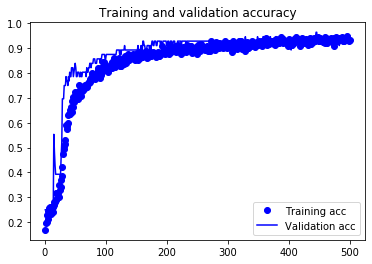

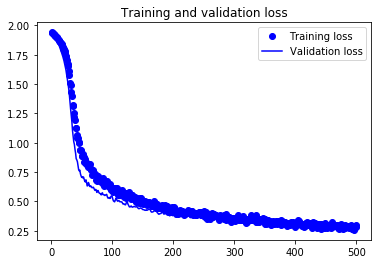

In [15]:
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs,val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [16]:
eval_speech_graph = tf.Graph()
eval_speech_sess = tf.Session(graph=eval_speech_graph)

keras.backend.set_session(eval_speech_sess)
with eval_speech_graph.as_default():
    keras.backend.set_learning_phase(0)
    eval_model = build_urban_model()

    #For quantization aware training only
    #tf.contrib.quantize.create_eval_graph(input_graph=eval_speech_graph)
    eval_speech_graph_def = eval_speech_graph.as_graph_def()
    saver = tf.train.Saver()
    saver.restore(eval_speech_sess, 'checkpoints')

    frozen_graph_def = tf.graph_util.convert_variables_to_constants( eval_speech_sess, eval_speech_graph_def, 
                                                                    [eval_model.output.op.name] )

    with open('frozen_urban_model.pb', 'wb') as f:
      f.write(frozen_graph_def.SerializeToString())

INFO:tensorflow:Restoring parameters from checkpoints
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


In [0]:
import pathlib

tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

converter = tf.lite.TFLiteConverter.from_frozen_graph( "frozen_urban_model.pb", ["conv2d_1_input"], ["dense_2/Softmax"])
tflite_model = converter.convert()

In [0]:
tflite_models_dir = pathlib.Path("/tmp/ESC50-split-models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [19]:
tflite_model_file = tflite_models_dir/"esc50-split-model.tflite"
tflite_model_file.write_bytes(tflite_model)

87500

In [20]:
!ls -lh {tflite_models_dir}

total 88K
-rw-r--r-- 1 root root 86K Oct 25 07:01 esc50-split-model.tflite


In [0]:
# Optimize for size
tf.logging.set_verbosity(tf.logging.INFO)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [0]:
# Create quantized values with an accurate dynamic range of activations, 
# for that need to provide a representative dataset

#sounds = tf.cast(X_train, tf.float32)/1000.0
sounds = tf.cast(X_train, tf.float32)
urban_ds = tf.data.Dataset.from_tensor_slices((sounds)).batch(1)
def representative_data_gen():
  for input_value in urban_ds.take(100):
    yield [input_value]
    
converter.representative_dataset = representative_data_gen

In [23]:
# tflite format quantized
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"esc50-split-model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

31120

In [24]:
!ls -lh {tflite_models_dir}

total 120K
-rw-r--r-- 1 root root 31K Oct 25 07:02 esc50-split-model_quant.tflite
-rw-r--r-- 1 root root 86K Oct 25 07:01 esc50-split-model.tflite


In [25]:
# The converted model needs to be fully quantized. That means all ops need to be 
# quantized, no floats left. The input and outputs need to be integers too.

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"esc50-split-model_quant_io.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

31192

In [26]:
!ls -lh {tflite_models_dir}

total 152K
-rw-r--r-- 1 root root 31K Oct 25 07:02 esc50-split-model_quant_io.tflite
-rw-r--r-- 1 root root 31K Oct 25 07:02 esc50-split-model_quant.tflite
-rw-r--r-- 1 root root 86K Oct 25 07:01 esc50-split-model.tflite


In [27]:
# Load data for float model
#sounds = tf.cast(X_test, tf.float32)/1000.0
sounds = tf.cast(X_test, tf.float32)
urban_ds = tf.data.Dataset.from_tensor_slices(sounds).batch(1)

X_train_flat = X_train.flatten()
X_train_max = max(X_train_flat)
X_train_min = min(X_train_flat)
print(X_train_max)
print(X_train_min)
# Load data for quantized model
X_test_flat = X_test.flatten()
X_test_max = max(X_test_flat)
X_test_min = min(X_test_flat)
print(X_test_max)
print(X_test_min)
quant_sounds = tf.quantization.quantize(X_test, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
#quant_sounds = tf.quantization.quantize(X_test, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
sounds_uint8 = tf.cast(quant_sounds[0], tf.uint8)
urban_ds_uint8 = tf.data.Dataset.from_tensor_slices(sounds_uint8).batch(1)

#print(sounds_uint8)
#print(X_test)

3.3819406666629184
-8.011448957055144
2.8659099536251444
-7.413998314541579


### The test files normalized individually did not work

In [0]:
#data1
dog_flat = dog_file1.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file1, dog_min, dog_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_1 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file1.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file1, clapping_min, clapping_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_1 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file1.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file1, door_knock_min , door_knock_max , tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_1 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file1.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file1, clock_alarm_min, clock_alarm_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_1 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file1.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file1, glass_breaking_min, glass_breaking_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_1 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file1.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file1, fireworks_min, fireworks_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_1 = tf.cast(quant_fireworks[0], tf.uint8)





#data2
dog_flat = dog_file2.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file2, dog_min, dog_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_2 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file2.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file2, clapping_min, clapping_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_2 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file2.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file2, door_knock_min, door_knock_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_2 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file2.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file2, clock_alarm_min, clock_alarm_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_2 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file2.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file2, glass_breaking_min, glass_breaking_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_2 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file2.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file2, fireworks_min, fireworks_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_2 = tf.cast(quant_fireworks[0], tf.uint8)



#data3
dog_flat = dog_file3.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file3, dog_min, dog_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_3 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file3.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file3, clapping_min, clapping_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_3 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file3.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file3, door_knock_min, door_knock_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_3 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file3.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file3, clock_alarm_min, clock_alarm_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_3 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file3.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file3, glass_breaking_min, glass_breaking_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_3 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file3.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file3, fireworks_min, fireworks_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_3 = tf.cast(quant_fireworks[0], tf.uint8)

### The test files worked with dataset distribution parameters

In [0]:
#data1
dog_flat = dog_file1.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_1 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file1.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_1 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file1.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_1 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file1.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_1 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file1.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_1 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file1.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_1 = tf.cast(quant_fireworks[0], tf.uint8)





#data2
dog_flat = dog_file2.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_2 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file2.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_2 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file2.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_2 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file2.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_2 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file2.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_2 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file2.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_2 = tf.cast(quant_fireworks[0], tf.uint8)



#data3
dog_flat = dog_file3.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file3, X_train_min, dog_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_3 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file3.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file3, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_3 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file3.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file3, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_3 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file3.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file3, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_3 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file3.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file3, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_3 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file3.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file3, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_3 = tf.cast(quant_fireworks[0], tf.uint8)                                           

In [0]:
np.save('/content/' + 'dog_single_uint8_1.npy', dog_uint8_1)
np.save('/content/' + 'clapping_single_uint8_1.npy', clapping_uint8_1)
np.save('/content/' + 'door_knock_single_uint8_1.npy', door_knock_uint8_1)
np.save('/content/' + 'clock_alarm_single_uint8_1.npy', clock_alarm_uint8_1 )
np.save('/content/' + 'glass_breaking_single_uint8_1.npy', glass_breaking_uint8_1)
np.save('/content/' + 'fireworks_single_uint8_1.npy', fireworks_uint8_1 )


np.save('/content/' + 'dog_single_uint8_2.npy', dog_uint8_2)
np.save('/content/' + 'clapping_single_uint8_2.npy', clapping_uint8_2)
np.save('/content/' + 'door_knock_single_uint8_2.npy', door_knock_uint8_2)
np.save('/content/' + 'clock_alarm_single_uint8_2.npy', clock_alarm_uint8_2 )
np.save('/content/' + 'glass_breaking_single_uint8_2.npy', glass_breaking_uint8_2)
np.save('/content/' + 'fireworks_single_uint8_2.npy', fireworks_uint8_2 )



np.save('/content/' + 'dog_single_uint8_3.npy', dog_uint8_3)
np.save('/content/' + 'clapping_single_uint8_3.npy', clapping_uint8_3)
np.save('/content/' + 'door_knock_single_uint8_3.npy', door_knock_uint8_3)
np.save('/content/' + 'clock_alarm_single_uint8_3.npy', clock_alarm_uint8_3 )
np.save('/content/' + 'glass_breaking_single_uint8_3.npy', glass_breaking_uint8_3)
np.save('/content/' + 'fireworks_single_uint8_3.npy', fireworks_uint8_3 )


### run model with tflite interpreter

In [0]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [0]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [36]:
i=0
for sound in urban_ds:
  #for list in sound:
    
    #break
  if i == 15:
   break
  i= i+1
  
  #print(list[1])

print(sound.shape)
#print(list.shape)
interpreter.set_tensor(interpreter.get_input_details()[0]["index"], sound)
interpreter.invoke()
predictions = interpreter.get_tensor(
    interpreter.get_output_details()[0]["index"])

print(predictions)


(1, 14, 51, 1)
[[2.0617385e-06 9.9846953e-01 4.4634115e-04 1.0774948e-03 1.1565769e-06
  3.3091906e-06]]


In [37]:
i=0
for sound in urban_ds_uint8:
  
  if i == 15:
    break
  i= i+1
#print(sound)
interpreter_quant.set_tensor(
    interpreter_quant.get_input_details()[0]["index"], sound)
interpreter_quant.invoke()
predictions = interpreter_quant.get_tensor(
    interpreter_quant.get_output_details()[0]["index"])

print(predictions)

[[  0 255   0   0   0   0]]
